# Libraries and Dependencies

In [40]:
import os
import random
from concurrent.futures import ThreadPoolExecutor

import cv2 as cv
import numpy as np
import pyvips
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

# Utilities and Helper functions

In [41]:
def highest_divisor(n):
    if n <= 1:
        return None  
    
    for i in range(int(n**0.5), 0, -1):
        if n % i == 0:
            return n // i if n // i != n else i

In [42]:
def apply_gamma_correction(img, gamma):
  lookUpTable = np.empty((1,256), np.uint8)
  for i in range(256):
      lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
  return cv.LUT(img, lookUpTable)

In [43]:
def pyvips_to_numpy(vips_image):
    return np.ndarray(buffer=vips_image.write_to_memory(),
                      dtype=np.uint8,
                      shape=[vips_image.height, vips_image.width, vips_image.bands])

In [67]:
def process_tile(slide, width, height, x, y, patch_size_w, patch_size_h, lower_bnd_intensity, upper_bnd_intensity, fdir):
    patch_coordinates = []
    actual_patch_w = min(patch_size_w, width - x)
    actual_patch_h = min(patch_size_h, height - y)
    
    patch_coordinates.append((x, y, actual_patch_w, actual_patch_h))
    
    tile = slide.crop(x, y, actual_patch_w, actual_patch_h)

    tile_array = pyvips_to_numpy(tile)

    mean_value = np.mean(tile_array)

    if lower_bnd_intensity < mean_value <= upper_bnd_intensity:
        return None
    
    output_filename = f"{fdir}/tile_{x}_{y}.jpg"
    coordinates = x, y, x + patch_size_w, y + patch_size_h
    tile.write_to_file(output_filename)
    
    return output_filename

## The following tile generator function gets some inputs:
-   Image file path
-   pPatch type (square, rectangle, or fixed):
    -   if fixed, fixed patch width:
    -   if fixed, fixed patch height:
-   Number of random tiles to generate:
-   Lower intensity bound
-   Upper intensity bound

In [68]:
def generate_random_tiles():
    image_path = os.path.expanduser(input("Enter the image file path: "))
    slide = pyvips.Image.new_from_file(image_path)
    width = slide.width
    height = slide.height
    
    patch_type = input("Enter patch type (square, rectangle, or fixed): ")

    fixed_w, fixed_h = None, None
    min_size, max_size = None, None

    if patch_type == "fixed":
        fixed_w = int(input("Enter fixed patch width: "))
        fixed_h = int(input("Enter fixed patch height: "))
        fdir = "Tile" + str(fixed_h) + str(fixed_w) + "_" + image_path[-6:-5]
    else:
        min_size = int(input("Enter the lower bound for patch size: "))
        max_size = int(input("Enter the upper bound for patch size: "))
        fdir = "Tile_" + str(min_size) +  "_" + str(max_size) + "_" + image_path[-6:-5]

    os.mkdir(fdir)
    num_tiles = int(input("Enter the number of random tiles to generate: "))
    lower_bnd_intensity = int(input("Enter the lower intensity bound: "))
    upper_bnd_intensity = int(input("Enter the upper intensity bound: "))

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = []
        
        for _ in range(num_tiles):
            x = random.randint(0, width - 800) 
            y = random.randint(0, height - 800)
            
            if patch_type == "square":
                patch_size_w = patch_size_h = random.randint(min_size, max_size)
                
            elif patch_type == "rectangle":
                patch_size_w = random.randint(min_size, max_size)
                patch_size_h = random.randint(min_size, max_size)
                
            elif patch_type == "fixed":
                patch_size_w = fixed_w
                patch_size_h = fixed_h
                
            else:
                raise ValueError(f"Unknown patch type: {patch_type}")
            
            futures.append(executor.submit(process_tile, slide, width, height, x, y, patch_size_w, patch_size_h, lower_bnd_intensity, upper_bnd_intensity, fdir))

        # Wait for all tasks to complete
        for future in futures:
            result = future.result()
            if result:
                print(f"Saved: {result}")

In [69]:
generate_random_tiles()
# Enter the image file path:  ../../Data/ALI surgical/ALI surgical w catheter m #1.mrxs
# Enter patch type (square, rectangle, or fixed):  fixed
# Enter fixed patch width:  3000
# Enter fixed patch height:  1000
# Enter the number of random tiles to generate:  200
# Enter the lower intensity bound:  248
# Enter the upper intensity bound:  255

Saved: Tile_150_900_1/tile_36563_141653.jpg
Saved: Tile_150_900_1/tile_25265_82575.jpg
Saved: Tile_150_900_1/tile_50547_166788.jpg
Saved: Tile_150_900_1/tile_28682_56372.jpg
Saved: Tile_150_900_1/tile_42992_139381.jpg
Saved: Tile_150_900_1/tile_39844_167987.jpg
Saved: Tile_150_900_1/tile_48274_144619.jpg


# This version generates fixed tiles from slides by sliding the tile window throughout the entire slide.





-   Parallel execution of the code using 'ThreadPoolExecutor' and using maximum core

In [76]:
def process_tile_2(x, y, patch_size_w, patch_size_h, lower_bnd_intensity, upper_bnd_intensity, file_path, output_dir):
    patch_coordinates = []
    # Calculate the actual patch size (to handle edges)
    actual_patch_w = min(patch_size_w, width - x)
    actual_patch_h = min(patch_size_h, height - y)
    
    patch_coordinates.append((x, y, actual_patch_w, actual_patch_h))
    
    # Crop the tile
    tile = slide.crop(x, y, actual_patch_w, actual_patch_h)

    # Convert tile to NumPy array
    tile_array = pyvips_to_numpy(tile)

    # Calculate the mean using NumPy
    mean_value = np.mean(tile_array)

    # Skip if the mean is within the range to be ignored
    if lower_bnd_intensity < mean_value <= upper_bnd_intensity:
        return None
    
    # Write the tile to a file only if necessary
    output_filename = os.path.expanduser(f"{output_dir}/tile_{x}_{y}.jpg")
    coordinates = x, y, x + patch_size_w, y + patch_size_h
    tile.write_to_file(output_filename)
    
    return output_filename

In [77]:
def generate_tiles(patch_size_w, patch_size_h, lower_bnd_intensity, upper_bnd_intensity, file_path,output_dir):
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = []
        for y in range(0, height, patch_size_h):
            for x in range(0, width, patch_size_w):
                futures.append(executor.submit(process_tile_2, x, y, patch_size_w, patch_size_h, lower_bnd_intensity, upper_bnd_intensity, file_path,output_dir))

        # Wait for all tasks to complete
        for future in futures:
            result = future.result()

In [78]:
patch_size_w = 2500
patch_size_h = 1000

for i in tqdm(range(1, 9), desc="Processing images"):
    # Load the image
    file_path = os.path.expanduser(f"~/Documents/Data/ALI surgical/ALI surgical w catheter m #{str(i)}.mrxs")
    output_dir = os.path.expanduser(f"~/Documents/Code/Lung_Injury/Tiles_{patch_size_h}_{patch_size_w}_{i}")
    os.makedirs(output_dir, exist_ok=True) 
    slide = pyvips.Image.new_from_file(file_path)
    width = slide.width
    height = slide.height

    generate_tiles(
        patch_size_w=patch_size_w,
        patch_size_h=patch_size_h,
        lower_bnd_intensity=240,
        upper_bnd_intensity=255,
        file_path=file_path,
        output_dir=output_dir
    )

Processing images: 100%|██████████| 8/8 [09:14<00:00, 69.27s/it]


In [ ]:
im = cv.imread("Tiles_5/tile_25000_142000.jpg")[:,:,1].copy()
# im = cv.medianBlur(im, ksize=3)
plt.imshow(im,cmap='gray')

In [ ]:
bg = cv.medianBlur(im, ksize=115)
plt.imshow(bg,cmap='gray')

In [ ]:
signal = cv.subtract(im, bg)
plt.imshow(signal,cmap='gray')

In [ ]:
signal = (im / im.max() * 255).astype(np.uint8)
plt.imshow(signal,cmap='gray')

In [ ]:
smooth = cv.GaussianBlur(signal, ksize=None, sigmaX=2)
plt.imshow(smooth,cmap='gray')

In [ ]:
valmask = (smooth > 190)
plt.imshow(valmask,cmap='gray')

In [ ]:
from scipy import ndimage


# Binarizing the image (convert to black and white)
binary_image = valmask < 0.5  # assuming black is the target to count

# Label the connected components
labeled_image, num_features = ndimage.label(binary_image)

# Plot the labeled image
plt.figure(figsize=(6, 6))
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.title(f'Number of objects: {num_features}')
plt.show()

num_features  # Return the count of objects (dots)


# gpt help

In [2]:
import cv2
tile = cv.imread("Tiles_5/tile_25000_142000.jpg")
gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)


In [3]:
blurred = cv2.GaussianBlur(gray_tile, (5, 5), 0)

In [ ]:
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

In [ ]:
# Optional

import numpy as np

# Find sure background area
sure_bg = cv2.dilate(closing, kernel, iterations=3)

# Distance transform and threshold
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Marker labelling
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Connected components
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(tile, markers)
tile[markers == -1] = [255, 0, 0]  # Mark boundaries in red

In [ ]:
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
count = 0

for contour in contours:
    area = cv2.contourArea(contour)
    if 50 < area < 1000:  # Set thresholds for area based on average neutrophil size
        # Use shape checks for irregular shapes (e.g., bean, L-shape, J-shape)
        count += 1

print(f"Number of Neutrophils: {count}")

In [ ]:
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    neutrophil_patch = tile[y:y+h, x:x+w]
    cv2.imwrite(f"test/neutrophil_{i}.png", neutrophil_patch)

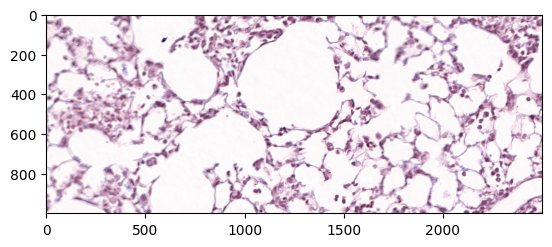

In [6]:
file_name = "tile_25000_52000.jpg"
tile = cv2.imread('Tiles_1000_2500_1/'+file_name)
plt.imshow(tile)

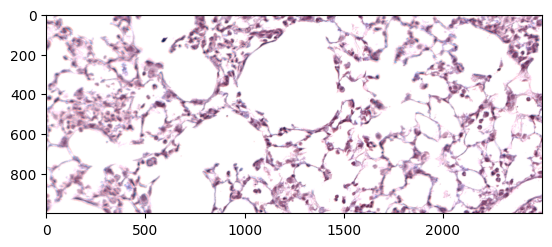

In [7]:
tile[tile > 230] = 255
plt.imshow(tile)

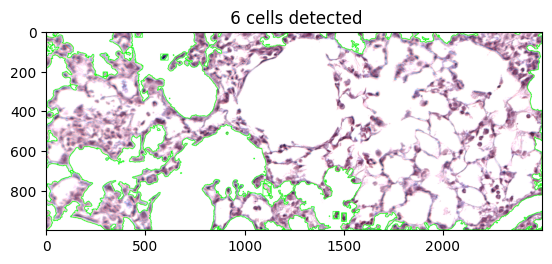

In [8]:


# Load the tile image
# file_name = "tile_25000_52000.jpg"
# tile = cv2.imread('Tiles_1000_2500_1/'+file_name)  # Replace 'your_tile_image.png' with your actual image file

# Step 1: Convert to grayscale and apply histogram equalization
gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray_tile)

# Step 2: Threshold using Otsu's method
_, thresh = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Morphological opening to remove small white regions
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step 4: Find contours and filter based on size and circularity
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(tile, contours, -1, (0, 255, 0), 2)  # Draw outer boundaries in green

count = 0
for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        continue

    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    # Filter by area and circularity
    if 300 < area < 2000 and 0.3 < circularity < 8:  # Adjust thresholds based on typical neutrophil properties
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(tile, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green bounding box
        count += 1


# fig = px.imshow(tile)
# fig.show()
plt.imshow(tile)
plt.title(f" {count} cells detected")
plt.savefig(file_name, dpi=600)


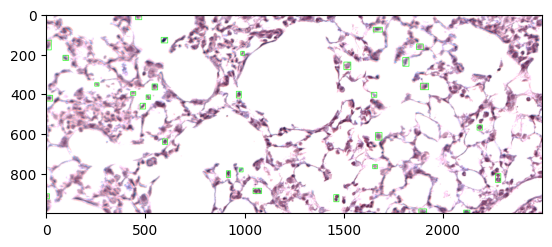

In [4]:
file_name = "tile_25000_52000.jpg"
tile = cv2.imread('Tiles_1000_2500_1/'+file_name)
tile[tile > 220] = 255

# Step 1: Convert to grayscale
gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)

# Step 2: Thresholding using Otsu's method
_, thresh = cv2.threshold(gray_tile, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 3: Find the external contours (outer boundaries)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the outer regions
mask = np.zeros_like(gray_tile)

# Draw the external contours on the mask (fill in the contours)
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

# Step 4: Invert the mask to focus on internal regions
internal_mask = cv2.bitwise_not(mask)

# Step 5: Apply the internal mask to the original thresholded image to isolate internal regions
internal_only = cv2.bitwise_and(thresh, thresh, mask=internal_mask)

# Step 6: Detect internal contours in the isolated regions
internal_contours, _ = cv2.findContours(internal_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the original contours in green and internal contours in blue for better visualization
# cv2.drawContours(tile, contours, -1, (0, 255, 0), 2)  # Draw outer boundaries in green
# cv2.drawContours(tile, internal_contours, -1, (255, 0, 0), 2)  # Draw internal contours in blue

# plt.imshow(tile)

for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        continue

    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter * perimeter))

    # Filter by area and circularity
    if 200 < area < 1000 and 0.5 < circularity < 1:
        # Get bounding box for the detected cell
        x, y, w, h = cv2.boundingRect(contour)
        
        # Define a padding for the neighborhood
        padding = 700  # Pixels to expand around the bounding box
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(tile.shape[1], x + w + padding)
        y_end = min(tile.shape[0], y + h + padding)

        # Extract the neighborhood region around the cell
        neighborhood = thresh[y_start:y_end, x_start:x_end]

        # Calculate the percentage of white pixels in the neighborhood
        total_pixels = neighborhood.size
        white_pixels = cv2.countNonZero(neighborhood)
        white_percentage = white_pixels / total_pixels

        # Check if the majority of the neighborhood is white (> threshold)
        if white_percentage > 0.1:  # You can adjust this threshold as needed
            # Draw the bounding box on the original tile image to indicate detection in open space
            cv2.rectangle(tile, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box for cells in open space

# Step 5: Display the improved tile image with bounding boxes

plt.imshow(tile)
plt.savefig(file_name, dpi=600)